# Zalo collection

## Connect to zalo cluster db

In [1]:
import weaviate
import weaviate.classes as wvc
from weaviate.classes.query import Filter
from weaviate.classes.config import Configure
import os
# import requests
from dotenv import load_dotenv

load_dotenv()

# Best practice: store your credentials in environment variables
wcd_url = os.environ["WCD_URL_2"]
wcd_api_key = os.environ['WCD_APIKEY_2']
huggingface_key = os.environ['HUGGINGFACE_WEAVIATE']
headers = {
    "X-HuggingFace-Api-Key": huggingface_key,
}


zalo_client = weaviate.connect_to_weaviate_cloud(
    cluster_url=wcd_url,                                    # Replace with your Weaviate Cloud URL
    auth_credentials=wvc.init.Auth.api_key(wcd_api_key),    # Replace with your Weaviate Cloud key           
    headers=headers,
    additional_config=wvc.init.AdditionalConfig(timeout=wvc.init.Timeout(init=100))     
)

## Create new zalo collection

In [7]:
zalo_collection = zalo_client.collections.create(
        name="Legalcorpus",
        properties=[
            wvc.config.Property(
                name="number",
                data_type=wvc.config.DataType.TEXT,
                vectorize_property_name=False,
                skip_vectorization=True
            ),
            wvc.config.Property(
                name="lawid",
                data_type=wvc.config.DataType.TEXT,
                vectorize_property_name=False,
                skip_vectorization=True
            ),
            wvc.config.Property(
                name="article_id",
                data_type=wvc.config.DataType.TEXT,  
                vectorize_property_name=False,
                skip_vectorization=True
            ),
            wvc.config.Property(
                name="title",
                data_type=wvc.config.DataType.TEXT,
                vectorize_property_name=False,
                skip_vectorization=True
            ),
            wvc.config.Property(
                name="text",
                data_type=wvc.config.DataType.TEXT,
                vectorize_property_name=False,
                skip_vectorization=True
            ),
        ],
        inverted_index_config=wvc.config.Configure.inverted_index(
            index_null_state=True,
            index_property_length=True,
            index_timestamps=True
        ),
    )
zalo_collection = zalo_client.collections.get(name="legalcorpus")

In [2]:
zalo_collection = zalo_client.collections.get(name="Legalcorpus")

In [6]:
zalo_client.collections.delete(name="Legalcorpus")

## Load data to upload to cloud

In [8]:
import json
with open('E:\\Code\\DeepLeaning\\zalo_chunks.jsonl', 'r', encoding="utf-8") as f:
    zalo_data = [json.loads(line) for line in f]
    
len(zalo_data)


106933

In [6]:
zalo_data[0]

{'number': '1',
 'lawid:': '01/2009/tt-bnn',
 'article_id': '1',
 'title': 'Điều 1. Phạm vi áp dụng',
 'text': 'Thông tư này hướng dẫn tuần tra, canh gác bảo vệ đê Điều trong mùa lũ đối với các tuyến đê sông được phân loại, phân cấp theo quy định tại Điều 4 của Luật Đê Điều.'}

In [10]:
import pickle
for i in range(6):
    temp_data = zalo_data[i * 20000: (i + 1) * 20000]
    if i == 5:
        temp_data = zalo_data[i * 20000:]
    
    with open(f"E:\\Code\\DeepLeaning\\Vietnamese-legal-retriever\\data\\zalo_embeddings_bkai_synthetic\\zalo_embeddings_{i}.pkl", "rb") as f:
        embeddings = pickle.load(f)
    
    print(len(temp_data),len(embeddings))
    if len(embeddings) == len(temp_data):
        with zalo_collection.batch.dynamic() as batch:
            for idx, doc in enumerate(temp_data):
                batch.add_object(
                    properties=doc,
                    vector=embeddings[idx]
                )
    else:
        print("Error")
        break
    



20000 20000
20000 20000
20000 20000
20000 20000
20000 20000
6933 6933


In [14]:
embeddings[0][0]

-0.07930457

## Read all object

In [20]:
count = 0
for item in zalo_collection.iterator(include_vector=True):
    count += 1

print(count)

106933


In [7]:
for item in zalo_collection.iterator(include_vector=True):
    print(item.properties)
    print(item.vector)

{'text': 'Thông tư này hướng dẫn tuần tra, canh gác bảo vệ đê Điều trong mùa lũ đối với các tuyến đê sông được phân loại, phân cấp theo quy định tại Điều 4 của Luật Đê Điều.', 'number': '1', 'title': 'Điều 1. Phạm vi áp dụng', 'lawid': '01/2009/tt-bnn', 'article_id': '1'}
{}


## Mine hard negative

In [3]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('bkai-foundation-models/vietnamese-bi-encoder')

model._modules

c:\Users\legen\anaconda3\envs\legal-retriever\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


OrderedDict([('0',
              Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: RobertaModel ),
             ('1',
              Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True}))])

In [4]:
from FlagEmbedding import FlagReranker
from underthesea import word_tokenize

reranker = FlagReranker("BAAI/bge-reranker-v2-m3",use_fp16=True)

In [5]:
import json
with open("E:\\Code\\DeepLeaning\\zalo_train_data.json", "r", encoding="utf-8") as f:
    data = json.load(f)

len(data)

2556

In [7]:
train_data = []

for sample in data:
    question = sample["question"]
    question_embedding = model.encode(word_tokenize(question, format="text"))
    neg = []
    pos = []

    response = zalo_collection.query.near_vector(question_embedding, limit=20)
    
    for o in response.objects:
        insert_neg = True
        for relevant_article in sample["relevant_articles"]:
            if o.properties["lawid"] == relevant_article["law_id"] and o.properties["article_id"] == relevant_article["article_id"]:
                insert_neg = False
                break
        if insert_neg:
            neg.append(f"{o.properties['title']}: {o.properties['text']}".lower())
    
    if len(neg) == 0:
        continue
            
    for relevant_article in sample["relevant_articles"]:
        response = zalo_collection.query.fetch_objects(filters=Filter.by_property("lawid").equal(relevant_article["law_id"]) & Filter.by_property("article_id").equal(relevant_article["article_id"]))

        for o in response.objects:
            pos.append(f"{o.properties['title']}: {o.properties['text']}".lower())
            
    pos_pairs = [[question, p] for p in pos]
    neg_pairs = [[question, n] for n in neg]
    pos_scores = reranker.compute_score(pos_pairs, normalize=True)
    neg_scores = reranker.compute_score(neg_pairs, normalize=True)
    
    pos = [positive for positive, score in sorted(zip(pos, pos_scores), key=lambda pair: pair[1], reverse=True) if score > 0.7]
    neg = [negative for negative, score in sorted(zip(neg, neg_scores), key=lambda pair: pair[1], reverse=True) if score > 0.5]
    if len(pos) == 0:
        continue

    
    ratio  = len(neg) // len(pos)
    if ratio < 1:
        for i in range(len(neg)):
            train_data.append({"question": question, "positive": pos[i], "negative": neg[i]})
        for i in range(len(neg), len(pos)):
            train_data.append({"question": question, "positive": pos[i]})
    else:
        neg = neg[:len(pos)]
        for i in range(len(pos)):
            train_data.append({"question": question, "positive": pos[i], "negative": neg[i]})

import json


print(len(train_data))

with open("E:\\Code\\DeepLeaning\\zalo_train_data_with_neg.jsonl", "w", encoding="utf-8") as f:
    for item in train_data:
        f.write(json.dumps(item, ensure_ascii=False) + "\n")


4359


## Evaluate the accuracy of the retrieval module

In [11]:
import json
import pickle

with open("E:\\Code\\DeepLeaning\\zalo_test_data.json", "r", encoding="utf-8") as f:
    test_data = json.load(f)

with open("E:\\Code\\DeepLeaning\\Vietnamese-legal-retriever\\data\\zalo_embeddings_bkai_synthetic\\zalo_test_embedding.pkl", "rb") as f:
    query_embeddings = pickle.load(f)
    
print(len(test_data))
print(len(query_embeddings))


640
640


In [36]:
from FlagEmbedding import FlagReranker
reranker = FlagReranker('BAAI/bge-reranker-v2-m3', use_fp16=True)

In [12]:
mrr_100 = []
mrr_1 = []
mrr_10 = []

acc_1 = []
acc_10 = []
acc_100 = []

for idx, question in enumerate(test_data):
    query = question["question"]
    response = zalo_collection.query.near_vector(query_embeddings[idx], limit=100)
    found_idx = -1
    # pair = [[query, item.properties['text']] for item in response.objects]
    # scores = reranker.compute_score(pair)
    # rerank_objects = [ object[0] for object in sorted(list(zip(response.objects, scores)), key=lambda x: x[1], reverse=True)]
    # for idx, object in enumerate(rerank_objects):
    for idx, object in enumerate(response.objects):
        for relevant_article in question["relevant_articles"]:
            if object.properties["lawid"] == relevant_article["law_id"] and object.properties["article_id"] == relevant_article["article_id"]:
                found_idx = idx
                break
        if found_idx != -1:
            break
    if found_idx != -1:
        mrr_100.append(1/(found_idx + 1))
        acc_100.append(1)
        if found_idx == 0:
            mrr_1.append(1)
            acc_1.append(1)
        else:
            mrr_1.append(0)
            acc_1.append(0)
        if found_idx < 10:
            mrr_10.append(1/(found_idx + 1))
            acc_10.append(1)
        else:
            mrr_10.append(0)
            acc_10.append(0)
    else:
        mrr_100.append(0)
        mrr_1.append(0)
        mrr_10.append(0)
        acc_100.append(0)
        acc_1.append(0)
        acc_10.append(0)
        
mrr_count_1 = sum(mrr_1) / len(mrr_1)

mrr_count_10 = sum(mrr_10) / len(mrr_10)
    
mrr_count_100 = sum(mrr_100) / len(mrr_100)

print("Mrr @ 1: ", mrr_count_1)
print("Mrr @ 10: ", mrr_count_10)
print("Mrr @ 100: ", mrr_count_100)
print("\n")
acc_count_1 = sum(acc_1) / len(acc_1)
acc_count_10 = sum(acc_10) / len(acc_10)
acc_count_100 = sum(acc_100) / len(acc_100)

print("Acc @ 1: ", acc_count_1)
print("Acc @ 10: ", acc_count_10)
print("Acc @ 100: ", acc_count_100)
    

    
    


Mrr @ 1:  0.7078125
Mrr @ 10:  0.798529885912698
Mrr @ 100:  0.8013265733248194


Acc @ 1:  0.7078125
Acc @ 10:  0.94375
Acc @ 100:  0.9921875


## Query

## Close the connection


In [13]:
zalo_client.close()

# VBPL collection

## Connect vbpl cloud machine

In [1]:
import weaviate
import weaviate.classes as wvc
from weaviate.classes.query import Filter
from weaviate.classes.config import Configure
import os
# import requests
from dotenv import load_dotenv

load_dotenv()

# Best practice: store your credentials in environment variables
wcd_url = os.environ["WCD_URL_2"]
wcd_api_key = os.environ['WCD_APIKEY_2']
huggingface_key = os.environ['HUGGINGFACE_WEAVIATE']
headers = {
    "X-HuggingFace-Api-Key": huggingface_key,
}


vbpl_client = weaviate.connect_to_weaviate_cloud(
    cluster_url=wcd_url,                                    # Replace with your Weaviate Cloud URL
    auth_credentials=wvc.init.Auth.api_key(wcd_api_key),    # Replace with your Weaviate Cloud key           
    headers=headers,
    additional_config=wvc.init.AdditionalConfig(timeout=wvc.init.Timeout(init=100))     
)

## Create-delete vbpl collection

In [3]:
vbpl_collection = vbpl_client.collections.create(
        name="vbplcorpus",
        properties=[
            wvc.config.Property(
                name="number",
                data_type=wvc.config.DataType.TEXT,
                vectorize_property_name=False,
                skip_vectorization=True
            ),
            wvc.config.Property(
                name="lawid",
                data_type=wvc.config.DataType.TEXT,
                vectorize_property_name=False,
                skip_vectorization=True
            ),
            wvc.config.Property(
                name="status",
                data_type=wvc.config.DataType.TEXT,
                vectorize_property_name=False,
                skip_vectorization=True    
            ),
            wvc.config.Property(
                name="article_id",
                data_type=wvc.config.DataType.TEXT,  
                vectorize_property_name=False,
                skip_vectorization=True
            ),
            wvc.config.Property(
                name="title",
                data_type=wvc.config.DataType.TEXT,
                vectorize_property_name=False,
                skip_vectorization=True
            ),
            wvc.config.Property(
                name="text",
                data_type=wvc.config.DataType.TEXT,
                vectorize_property_name=False,
                skip_vectorization=True
            ),
            wvc.config.Property(
                name="tokenize_text",
                data_type=wvc.config.DataType.TEXT,
                vectorize_property_name=False,
                skip_vectorization=True
            ),
        ],
        inverted_index_config=wvc.config.Configure.inverted_index(
            index_null_state=True,
            index_property_length=True,
            index_timestamps=True
        ),
    )

In [2]:
vbpl_collection = vbpl_client.collections.get(name="vbplcorpus")

In [2]:
vbpl_client.collections.delete(name="vbplcorpus")

## Load data to upload to cloud

In [4]:
import json
with open("E:\\Code\\DeepLeaning\\Vietnamese-legal-retriever\\data\\vbpl_data\\chunk_0.jsonl", "r", encoding="utf-8") as f:
    vbpl_data = [json.loads(line) for line in f]

len(vbpl_data)

266817

In [5]:
import pickle
for i in range(14):
    temp_data = vbpl_data[i * 20000: (i + 1) * 20000]
    
    with open(f"E:\\Code\\DeepLeaning\\Vietnamese-legal-retriever\\data\\vbpl_embeddings_bkai_synthetic\\vbpl_embeddings_{i}.pkl", "rb") as f:
        embeddings = pickle.load(f)
    
    print(len(temp_data),len(embeddings))
    if len(embeddings) == len(temp_data):
        with vbpl_collection.batch.dynamic() as batch:
            for idx, doc in enumerate(temp_data):
                title = ', '.join(doc["title"])
                batch.add_object(
                    properties={
                        "number": doc["number"],
                        "lawid": doc["lawid"],
                        "status": doc["status"],
                        "title": title,
                        "article_id": None,
                        "text": doc["text"],
                        "tokenize_text": doc["tokenize_text"]
                    },
                    vector=embeddings[idx]
                )
    else:
        print("Error")
        break


20000 20000
20000 20000
20000 20000
20000 20000
20000 20000
20000 20000
20000 20000
20000 20000
20000 20000
20000 20000
20000 20000
20000 20000
20000 20000
6817 6817


{'message': 'Failed to send 1000 objects in a batch of 1000. Please inspect client.batch.failed_objects or collection.batch.failed_objects for the failed objects.'}
{'message': 'Failed to send 1000 objects in a batch of 1000. Please inspect client.batch.failed_objects or collection.batch.failed_objects for the failed objects.'}
{'message': 'Failed to send 1000 objects in a batch of 1000. Please inspect client.batch.failed_objects or collection.batch.failed_objects for the failed objects.'}
{'message': 'Failed to send 1000 objects in a batch of 1000. Please inspect client.batch.failed_objects or collection.batch.failed_objects for the failed objects.'}
{'message': 'Failed to send 1000 objects in a batch of 1000. Please inspect client.batch.failed_objects or collection.batch.failed_objects for the failed objects.'}
{'message': 'Failed to send 1000 objects in a batch of 1000. Please inspect client.batch.failed_objects or collection.batch.failed_objects for the failed objects.'}
{'message'

## Read objects

In [4]:
for item in vbpl_collection.iterator(include_vector=True):
    print(item.properties)
    print(item.vector)
    break

{'text': 'hành thống nhất tỷ lệ cho vay vốn lưu động các đơn vị sản xuất - kinh doanh thuộc các thành phần kinh tế khác nhau. Ngân hàng chuyên nghiệp được quyền hướng dẫn những quy định nghiệp vụ cụ thể sát hợp với điều kiện hoạt động của mình. 8. Việc cho vay vốn cố định các đơn vị kinh tế cũng được đặt trên cơ sở động viên cao nhất vốn tự có của đơn vị vay vốn. Khi cho vay, trước mắt các Ngân hàng chuyên nghiệp phải tập trung vốn phục vụ 3 chương trình kinh tế lớn là sản xuất chế biến lương thực - thực phẩm, hàng tiêu dùng và hàng xuất khẩu. Ngân hàng Nhà nước Việt nam ban hành thống nhất thể lệ cho vay vốn cố định các đơn vị sản xuất - kinh doanh thuộc các thành phần kinh tế khác nhau. Ngân hàng chuyên nghiệp được quyền hướng dẫn những quy định nghiệp vụ cụ thể sát họp với điều kiện hoạt động của mình.', 'number': '253724', 'lawid': '218-CT', 'tokenized_text': 'hành thống_nhất tỷ_lệ cho vay vốn_lưu_động các đơn_vị sản_xuất - kinh_doanh thuộc các thành_phần kinh_tế khác nhau . Ngân_h

In [35]:
count = 0
count_vector = 0
count_1 = 0
for item in vbpl_collection.iterator(include_vector=True):
    count += 1
    if len(item.vector) == 0:
        count_vector += 1
    if int(item.properties["number"]) < 15001:
        count_1 += 1
print(count)
print(count_1)
print(count_vector)

7296
7296
2


## Fliter query

In [7]:
import json
with open("E:\\Code\\DeepLeaning\\query_answer.jsonl", "r", encoding="utf-8") as f:
    qna_all_data = [json.loads(line) for line in f]
len(qna_all_data)

60038

In [8]:
import pickle
qna_filtered_data = []

for i in range(2):
    with open(f"E:\\Code\\DeepLeaning\\Vietnamese-legal-retriever\\data\\vbpl_embeddings_bkai_synthetic\\qna_embeddings_{i}.pkl", "rb") as f:
        question_embeddings = pickle.load(f)
    if i == 0:
        qna_data = qna_all_data[:30000]
    else:
        qna_data = qna_all_data[30000:]
    for idx, qna in enumerate(qna_data):
        if (int(qna["number"]) % 1000) == 1:
            print(f"Processing {qna['number']}")
        question = qna["question"]
        response = vbpl_collection.query.near_vector(question_embeddings[idx], limit=40)
        
        remove_flag = True
        for o in response.objects:
            if o.properties["number"] == qna["answer_idx"]:
            # if o.properties["lawid"] == qna["lawid"]:
                remove_flag = False
                break
        if not remove_flag:
            qna_filtered_data.append(qna)

len(qna_filtered_data)
            

Processing 1
Processing 1001
Processing 2001
Processing 3001
Processing 4001
Processing 5001
Processing 6001
Processing 7001
Processing 8001
Processing 9001
Processing 10001
Processing 11001
Processing 12001
Processing 13001
Processing 14001
Processing 15001
Processing 16001
Processing 17001
Processing 18001
Processing 19001
Processing 20001
Processing 21001
Processing 22001
Processing 23001
Processing 24001
Processing 25001
Processing 26001
Processing 27001
Processing 28001
Processing 29001
Processing 30001
Processing 31001
Processing 32001
Processing 33001
Processing 34001
Processing 35001
Processing 36001
Processing 37001
Processing 38001
Processing 39001
Processing 40001
Processing 41001
Processing 42001
Processing 43001
Processing 44001
Processing 45001
Processing 46001
Processing 47001
Processing 48001
Processing 49001
Processing 50001
Processing 51001
Processing 52001
Processing 53001
Processing 54001
Processing 55001
Processing 56001
Processing 57001
Processing 58001
Processing

43162

In [9]:
with open("E:\\Code\\DeepLeaning\\Vietnamese-legal-retriever\\data\\qna_filtered_data_on_chunkidx.jsonl", "w", encoding="utf-8") as f:
    for item in qna_filtered_data:
        f.write(json.dumps(item, ensure_ascii=False) + "\n")

## Mine the hard negatives

In [3]:
import json
import pickle
with open("E:\\Code\\DeepLeaning\\Vietnamese-legal-retriever\\data\\qna_filtered_train_data.jsonl", "r", encoding="utf-8") as f:
    train_data = [json.loads(line) for line in f]
print(len(train_data))

with open("E:\\Code\\DeepLeaning\\Vietnamese-legal-retriever\\data\\vbpl_embeddings_bkai_synthetic\\qna_train_embeddings.pkl", "rb") as f:
    query_embeddings = pickle.load(f)
    
len(query_embeddings)

38845


38845

In [4]:
import json
with open("E:\\Code\\DeepLeaning\\chunk_0.jsonl", 'r', encoding="utf-8") as f:
    chunks = [json.loads(line) for line in f]

len(chunks)

266817

In [5]:
new_train_data = []
neg = []

for idx, qna in enumerate(train_data):
    question = qna["question"]
    answer_idx = int(qna["answer_idx"])
    response = vbpl_collection.query.near_vector(query_embeddings[idx], limit=50)
    for o in response.objects:
        if o.properties["lawid"] != qna["lawid"]:
            neg.append(o.properties["text"])
        elif abs(int(o.properties["number"]) - int(qna["answer_idx"])) > 10:
            neg.append(o.properties["text"])
        if len(neg) == 5:
            break
    for text in neg:
        new_train_data.append({"query": question, "pos": chunks[answer_idx-1]['text'], "neg": text})     
    neg.clear()
    
len(new_train_data)
    

194225

In [6]:
with open("E:\\Code\\DeepLeaning\\Vietnamese-legal-retriever\\data\\qna_train_data_with_neg.json", "w", encoding="utf-8") as f:
    json.dump(new_train_data, f, ensure_ascii=False)

## Evaluate the accuracy of the vbpl test dataset

In [7]:
import json

with open("E:\\Code\\DeepLeaning\\Vietnamese-legal-retriever\\data\\vbpl_data\\qna_filtered_test_data.jsonl", "r", encoding="utf-8") as f:
    test_data = [json.loads(line) for line in f]
    
len(test_data)

4317

In [8]:
import pickle

with open("E:\\Code\\DeepLeaning\\Vietnamese-legal-retriever\\data\\vbpl_embeddings_bkai_synthetic\\qna_test_embeddings.pkl", "rb") as f:
    query_embeddings = pickle.load(f)
    
len(query_embeddings)

4317

In [9]:
from FlagEmbedding import FlagReranker
reranker = FlagReranker('BAAI/bge-reranker-v2-m3', use_fp16=True)

c:\Users\legen\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
mrr_100 = []
mrr_1 = []
mrr_10 = []

acc_1 = []
acc_10 = []
acc_100 = []

for idx, question in enumerate(test_data):
    query = question["question"]
    response = vbpl_collection.query.near_vector(query_embeddings[idx], limit=100)
    found_idx = -1
    
    pair = [[query, item.properties['text']] for item in response.objects]
    # scores = reranker.compute_score(pair)
    # rerank_objects = [ object[0] for object in sorted(list(zip(response.objects, scores)), key=lambda x: x[1], reverse=True)]
    # for idx, object in enumerate(rerank_objects):
    for idx, object in enumerate(response.objects):
        if object.properties["number"] == question["answer_idx"]:
            found_idx = idx
            break
    if found_idx != -1:
        mrr_100.append(1/(found_idx + 1))
        acc_100.append(1)
        if found_idx == 0:
            mrr_1.append(1)
            acc_1.append(1)
        else:
            mrr_1.append(0)
            acc_1.append(0)
        if found_idx < 10:
            mrr_10.append(1/(found_idx + 1))
            acc_10.append(1)
        else:
            mrr_10.append(0)
            acc_10.append(0)
    else:
        mrr_100.append(0)
        mrr_1.append(0)
        mrr_10.append(0)
        acc_100.append(0)
        acc_1.append(0)
        acc_10.append(0)
        
mrr_count_1 = sum(mrr_1) / len(mrr_1)

mrr_count_10 = sum(mrr_10) / len(mrr_10)
    
mrr_count_100 = sum(mrr_100) / len(mrr_100)

print("Mrr @ 1: ", mrr_count_1)
print("Mrr @ 10: ", mrr_count_10)
print("Mrr @ 100: ", mrr_count_100)
print("\n")
acc_count_1 = sum(acc_1) / len(acc_1)
acc_count_10 = sum(acc_10) / len(acc_10)
acc_count_100 = sum(acc_100) / len(acc_100)

print("Acc @ 1: ", acc_count_1)
print("Acc @ 10: ", acc_count_10)
print("Acc @ 100: ", acc_count_100)
    



Mrr @ 1:  0.43201297197127636
Mrr @ 10:  0.5965576293060658
Mrr @ 100:  0.6011447555621537


Acc @ 1:  0.43201297197127636
Acc @ 10:  0.906648135279129
Acc @ 100:  0.9962937224924716


## Close the connection

In [37]:
vbpl_client.close()

In [9]:
import json
with open("E:\\Code\\DeepLeaning\\zalo_qna_train_reformatted.json", "r", encoding="utf-8") as f:
    data = json.load(f)
    
len(data)

4823

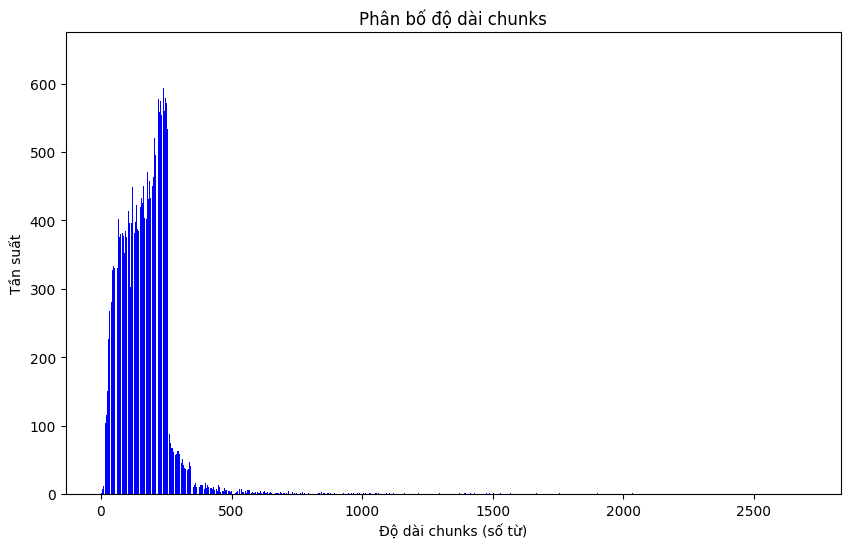

In [7]:
import matplotlib.pyplot as plt
import csv

# Đường dẫn đến tệp CSV
csv_file = 'E:\\Code\\DeepLeaning\\zalo_length_statistics.csv'

# Tạo danh sách trống cho trục x và y
x = []
y = []

# Mở tệp CSV và đọc dữ liệu
with open(csv_file, 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        x.append(int(row[0]))  # Thêm dữ liệu vào trục x
        y.append(int(row[1]))  # Thêm dữ liệu vào trục y

# Vẽ biểu đồ cột
plt.figure(figsize=(10, 6))
plt.bar(x, y, color='blue')  # Đặt màu cột thành xanh dương
plt.xlabel('Độ dài chunks (số từ)')
plt.ylabel('Tần suất')
plt.title('Phân bố độ dài chunks')



# Hiển thị biểu đồ
plt.show()
